<a href="https://colab.research.google.com/github/0jipy/192kbps_colab_JIPY/blob/main/61_%EB%84%A4%EC%9D%B4%EB%B2%84%EC%87%BC%ED%95%91%EB%A6%AC%EB%B7%B0_%EA%B0%90%EC%84%B1%EB%B6%84%EB%A5%98_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 네이버 쇼핑 리뷰 감성 분류 - GRU

- Mecab 설치

In [1]:
# Colab에 Mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab_light_220111.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 109 (delta 7), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (109/109), 1.27 MiB | 15.85 MiB/s, done.
Resolving deltas: 100% (46/46), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
     |████████████████████████████████| 19.4 MB 5.1 MB/s 
     |████████████████████████████████| 448 kB 50.1 MB/s 
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2022-01-26 06:46:09--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22cd:e0db, 2406:da00:ff00::22c0:3470, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Loc

# 데이터 탐색

In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
url = "https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt"
df = pd.read_table(url,  names=['ratings', 'reviews'])
df.head()

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


In [4]:
# vudwjadl 4,5 점인 데이터를 1(긍정) 나머지를 0(부정)
df['label'] = df.apply(lambda x: 1 if x.ratings > 3 else 0, axis=1)
df.head()

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1


In [5]:
# 각 열별로 중복 확인  # 리뷰는 80개 정도가 중복.
df.shape, df.ratings.nunique(), df.reviews.nunique()

((200000, 3), 4, 199908)

- 데이터 전처리 : 넘파이의 배열이 되기전에 데이터 전처리 하고 가자

In [6]:
# 한글 이외의 데이터 제거
df.reviews = df.reviews.str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '')

In [7]:
# 혹시 Null이 생길수 있으니 널 데이터가 생기면 제거
df.reviews.replace('', np.nan, inplace=True)
df.reviews.isnull().sum()

0

In [8]:
# 중복제거
df.drop_duplicates(subset=['reviews'], inplace=True)
df.shape

(199391, 3)

In [9]:
# Null값 확인 0 나오면 결측치가 없는것. 
df.isnull().sum().sum()

0

- 훈련 / 테스트 데이터 셋 분리

In [10]:
# 훈련 데이터 : 테스트 데이터 = 3 : 1
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.reviews.values, df.label.values, stratify=df.label.values,
    test_size=0.25, random_state=2022
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((149543,), (49848,), (149543,), (49848,))

In [11]:
# 훈련 데이터 레이블의 분포
np.unique(y_train, return_counts=True)

(array([0, 1]), array([74712, 74831]))

### 토큰화

In [12]:
from konlpy.tag import Mecab

In [13]:
mecab = Mecab( )
print(mecab.morphs('와 이런 것도 상품이라고 차라리 내가 만드는 게 나을 뻔'))

['와', '이런', '것', '도', '상품', '이', '라고', '차라리', '내', '가', '만드', '는', '게', '나을', '뻔']


In [14]:
stopwords = ['도','는','다','의','가','이','은','한','에','하','고','을','를','인','듯','과','와','네','들','듯','지','임','게']

In [15]:
X_train = [mecab.morphs(review) for review in X_train]
X_train = list(map(lambda s: [item for item in s if item not in stopwords], X_train))

In [16]:
# tokenized_list = []
# for review in X_train:
#     morphs = mecab.morphs(review)
#     morphs = [item for item in morphs if item not in stopwords]
#     tokenized_list.append(morphs)
# X_train = tokenized_list

In [17]:
print(X_train[0])

['보통', '소품', '샵', '에서', '원', '원', '는데', '여기', '서', '진짜', '저렴', '구매', '거', '같', '아요', '바다', '갈', '때', '구매', '시', '면', '인생', '샷', '건질', '수', '있', '어요']


In [18]:
X_test = [mecab.morphs(review) for review in X_test]
X_test = list(map(lambda s: [item for item in s if item not in stopwords], X_test))

In [19]:
# X_test = [mecab.morphs(review) for review in X_test]
# X_test = map(lambda s:[item for item in s if item not in stopwords], X_train)

# X_test = [item for item in X_test if item not in stopwords]

In [20]:
print(X_test[0])

['재', '구매', '몇', '번', '째', '주문', '인지', '모릅니다']


- 단어와 길이 분포 확인하기

In [21]:
# positive_word = X_train[y_train == 1]

In [22]:
positive_words = []
for i in range(len(y_train)):
    if y_train[i] == 1:
        positive_words += X_train[i]

In [23]:
from collections import Counter
Counter(['a','b','c'])

Counter({'a': 1, 'b': 1, 'c': 1})

In [24]:
positive_words_count = Counter(positive_words)
len(positive_words)

1019469

In [25]:
print(positive_words_count.most_common(20))

[('좋', 39613), ('아요', 21080), ('네요', 19951), ('어요', 18609), ('잘', 18529), ('구매', 16229), ('습니다', 13456), ('있', 12432), ('배송', 12244), ('는데', 11704), ('했', 9807), ('합니다', 9679), ('먹', 9587), ('재', 9323), ('너무', 8407), ('같', 7779), ('만족', 7228), ('거', 6467), ('어', 6324), ('쓰', 6306)]


In [26]:
negative_words = []
for i in range(len(y_train)):
    if y_train[i] == 0:
        negative_words += X_train[i]

In [27]:
negative_words_count = Counter(negative_words)
len(negative_words)
print(negative_words_count.most_common(20))

[('네요', 31887), ('는데', 20256), ('안', 19600), ('어요', 14827), ('너무', 13226), ('있', 13143), ('했', 11818), ('좋', 9731), ('배송', 9542), ('같', 9059), ('거', 8848), ('구매', 8801), ('어', 8754), ('아요', 8725), ('없', 8653), ('되', 8439), ('습니다', 8391), ('그냥', 8380), ('않', 8027), ('잘', 7993)]


- 토큰화를 위한 정수 인코딩. 

In [28]:
from tensorflow.keras.preprocessing.text import Tokenizer

tok = Tokenizer()
tok.fit_on_texts(X_train)

In [29]:
threshold = 2
total_cnt = len(tok.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

In [30]:
for key, value in tok.word_counts.items():  # 딕셔너리라서 items()
    total_freq += value
    if value < threshold:   # 단어의 등장 빈도가 threshold보다 작을 경우
        rare_cnt += 1
        rare_freq += value

In [31]:
print('단어 집합(vocabulary)의 크기 :',total_cnt)
print(f'등장 빈도가 {threshold-1}번 이하인 희귀 단어의 수: {rare_cnt}')
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 39977
등장 빈도가 1번 이하인 희귀 단어의 수: 18152
단어 집합에서 희귀 단어의 비율: 45.406108512394624
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.7907962331751044


- 등장 빈도가 2회 이하인 단어는 제외하고 토큰화
- 나는 쓰레스홀드2리서 등장빈도 1개 이하인 단어 제외 토큰화 될것

In [32]:
# 0번 패딩 토큰화 1번 OOV(out of value)토큰을 고려하여 +2  # 수업중 vocab_size sms 16957
vocab_size = total_cnt-rare_cnt + 2
vocab_size

21827

In [33]:
tokenizer = Tokenizer(vocab_size, oov_token='OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)   # 트랜스폼 트레인 버전으로 테스트도 바꿔줌?

리뷰의 최대 길이 : 83
리뷰의 평균 길이 : 15.349484763579706


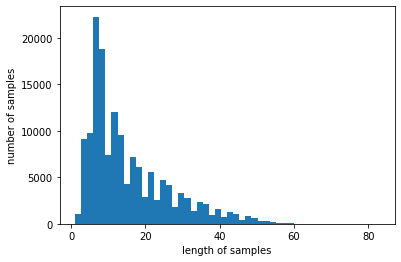

In [34]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [35]:
# 리뷰 길이를 60으로 패딩
max_len = 60

In [36]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

### GRU로 감성 분류
- 임베딩 벡터의 차원 : 100
- 은닉 상태의 크기 : 128

In [37]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, GRU, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [38]:
model = Sequential([
        Embedding(vocab_size, 100, input_length=max_len),
        GRU(128),
        Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 100)           2182700   
                                                                 
 gru (GRU)                   (None, 128)               88320     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 2,271,149
Trainable params: 2,271,149
Non-trainable params: 0
_________________________________________________________________


In [39]:
from tensorflow.python.keras.models import Model
model.compile('adam', 'binary_crossentropy', ['accuracy'])
model_path = 'best-shopping-gru.h5'
mc = ModelCheckpoint(model_path, save_best_only=True, verbose=1)
es = EarlyStopping(patience=5)

In [40]:
hist = model.fit(X_train, y_train, epochs=30, batch_size=128, 
                 validation_split=0.2, callbacks=[mc,es])

Epoch 1/30
932/935 [============================>.] - ETA: 0s - loss: 0.2848 - accuracy: 0.8910
Epoch 00001: val_loss improved from inf to 0.23942, saving model to best-shopping-gru.h5
935/935 [==============================] - 14s 10ms/step - loss: 0.2847 - accuracy: 0.8911 - val_loss: 0.2394 - val_accuracy: 0.9136
Epoch 2/30
932/935 [============================>.] - ETA: 0s - loss: 0.2056 - accuracy: 0.9272
Epoch 00002: val_loss improved from 0.23942 to 0.22247, saving model to best-shopping-gru.h5
935/935 [==============================] - 9s 10ms/step - loss: 0.2054 - accuracy: 0.9272 - val_loss: 0.2225 - val_accuracy: 0.9191
Epoch 3/30
930/935 [============================>.] - ETA: 0s - loss: 0.1693 - accuracy: 0.9406
Epoch 00003: val_loss did not improve from 0.22247
935/935 [==============================] - 9s 10ms/step - loss: 0.1693 - accuracy: 0.9406 - val_loss: 0.2272 - val_accuracy: 0.9186
Epoch 4/30
932/935 [============================>.] - ETA: 0s - loss: 0.1427 - acc

In [41]:
best_model = load_model(model_path)
best_model.evaluate(X_test, y_test)

1558/1558 [==============================] - 7s 4ms/step - loss: 0.2246 - accuracy: 0.9178


[0.2246016561985016, 0.9177700281143188]